In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import seaborn as sns

from pydicom.pixel_data_handlers.util import apply_voi_lut

sns.set_style("whitegrid")

BASELINE_ROOT = "../../dataset/baseline"
NPY_ROOT = os.path.join(BASELINE_ROOT, "NPY")
PNG_ROOT = os.path.join(BASELINE_ROOT, "PNG")
MANIFEST_PATH = os.path.join(BASELINE_ROOT, "manifest", "baseline_manifest.csv")

df = pd.read_csv(MANIFEST_PATH)
print("Total converted images:", len(df))

Total converted images: 20


In [55]:
df.head()

,split,label,y,src_dicom,png_path,png_sha256,orig_width,orig_height,pad_top,pad_bottom,pad_left,pad_right,final_size,baseline_range
0,train,TB,1,../../dataset/split_dataset/train/TB/dicom-stu...,../../dataset/baseline/PNG/train/TB/dicom-stud...,e9422fdf0f41b6bb37484543f009423b3fa9f587ebee56...,2208,2020,43,44,0,0,1024,0-255
1,train,TB,1,../../dataset/split_dataset/train/TB/dicom-stu...,../../dataset/baseline/PNG/train/TB/dicom-stud...,96a8fd75eed822b1124ca975716e1833c959b7edc4ed86...,2076,2414,0,0,71,72,1024,0-255
2,train,TB,1,../../dataset/split_dataset/train/TB/dicom-stu...,../../dataset/baseline/PNG/train/TB/dicom-stud...,179789a9ab6401f16547ca9ba3807f2025d0bd82a40648...,1984,2039,0,0,14,14,1024,0-255
3,train,TB,1,../../dataset/split_dataset/train/TB/dicom-stu...,../../dataset/baseline/PNG/train/TB/dicom-stud...,7b5d70a97e1e0bbfcbd3a3c394bf95710fa06fc3c49a8a...,1824,2108,0,0,69,69,1024,0-255
4,train,TB,1,../../dataset/split_dataset/train/TB/pacs_rslt...,../../dataset/baseline/PNG/train/TB/pacs_rslt-...,d5697fc9d5fabfa1cc4f4d5ca84f6fdcbec554819eb37e...,2336,2836,0,0,90,91,1024,0-255


In [56]:
df.tail()

,split,label,y,src_dicom,png_path,png_sha256,orig_width,orig_height,pad_top,pad_bottom,pad_left,pad_right,final_size,baseline_range
15,val,NonTB,0,../../dataset/split_dataset/val/NonTB/pacs_rsl...,../../dataset/baseline/PNG/val/NonTB/pacs_rslt...,3dd3b6739036162d300b905d9674a95ce8ae489f95681b...,2336,2836,0,0,90,91,1024,0-255
16,test,TB,1,../../dataset/split_dataset/test/TB/pacs_rslt-...,../../dataset/baseline/PNG/test/TB/pacs_rslt-d...,b49839f25d8608126e70e0144ba96357ada2ccd2685b41...,2336,2836,0,0,90,91,1024,0-255
17,test,TB,1,../../dataset/split_dataset/test/TB/dicom-stud...,../../dataset/baseline/PNG/test/TB/dicom-study...,adc43145421707a0e7ac01ac40a94d4e548edec49d9d06...,2272,2219,12,12,0,0,1024,0-255
18,test,NonTB,0,../../dataset/split_dataset/test/NonTB/Pacs-di...,../../dataset/baseline/PNG/test/NonTB/Pacs-dic...,e3b95b8248e43e10088776ce15631d07222f6ab30e10ce...,2336,2836,0,0,90,91,1024,0-255
19,test,NonTB,0,../../dataset/split_dataset/test/NonTB/pacs_rs...,../../dataset/baseline/PNG/test/NonTB/pacs_rsl...,15afa162856717b2809ea10c82ba76c0d9f5e295607530...,2336,2836,0,0,90,91,1024,0-255


In [57]:
for split in ["train", "val", "test"]:
    X = np.load(os.path.join(NPY_ROOT, split, "X.npy"))
    y = np.load(os.path.join(NPY_ROOT, split, "y.npy"))

    print(f"{split.upper():5s} | X.shape={X.shape}, y.shape={y.shape}")


TRAIN | X.shape=(12, 1024, 1024, 1), y.shape=(12,)
VAL   | X.shape=(4, 1024, 1024, 1), y.shape=(4,)
TEST  | X.shape=(4, 1024, 1024, 1), y.shape=(4,)


In [58]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

def load_raw_dicom(dcm_path):
    ds = pydicom.dcmread(dcm_path)
    img = ds.pixel_array.astype(np.float32)

    try:
        img = apply_voi_lut(img, ds)
    except Exception:
        pass

    mn, mx = img.min(), img.max()
    if mx > mn:
        img = (img - mn) / (mx - mn)

    return img


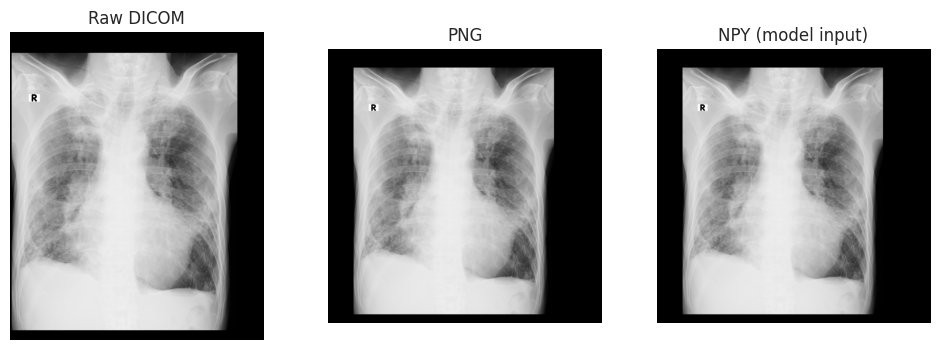

In [69]:
sample = df.head(20).iloc[18]

raw = load_raw_dicom(sample["src_dicom"])
png = cv2.imread(sample["png_path"], cv2.IMREAD_GRAYSCALE)
X = np.load(os.path.join(NPY_ROOT, sample["split"], "X.npy"))

idx = df[df["split"] == sample["split"]].index.get_loc(sample.name)
npy = X[idx, :, :, 0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(raw, cmap="gray")
ax[0].set_title("Raw DICOM")
ax[1].imshow(png, cmap="gray")
ax[1].set_title("PNG")
ax[2].imshow(npy, cmap="gray")
ax[2].set_title("NPY (model input)")
for a in ax: a.axis("off")
plt.show()


In [60]:
pad_cols = ["pad_top", "pad_bottom", "pad_left", "pad_right"]
df[pad_cols].describe()


,pad_top,pad_bottom,pad_left,pad_right
count,20.000000,20.000000,20.000000,20.000000
mean,2.750000,2.800000,74.400000,75.150000
std,9.845517,10.060867,32.128689,32.426881
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,70.500000,71.250000
50%,0.000000,0.000000,90.000000,91.000000
75%,0.000000,0.000000,90.000000,91.000000
max,43.000000,44.000000,108.000000,108.000000


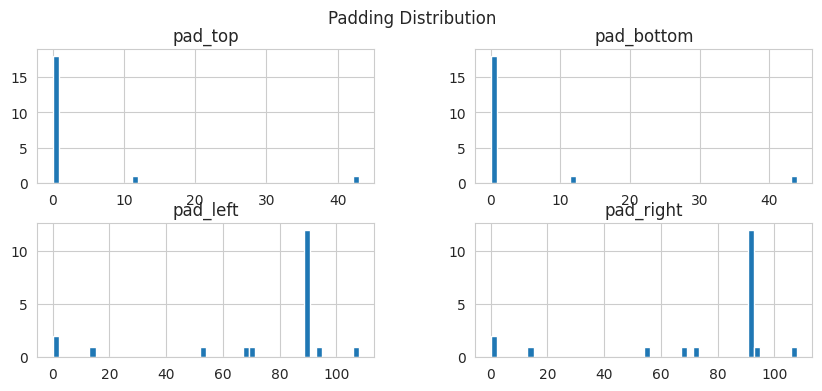

In [61]:
df[pad_cols].hist(bins=50, figsize=(10,4))
plt.suptitle("Padding Distribution")
plt.show()


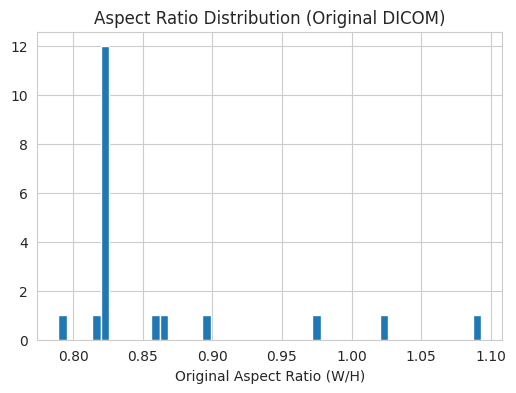

In [62]:
df["aspect_ratio_orig"] = df["orig_width"] / df["orig_height"]

plt.figure(figsize=(6,4))
plt.hist(df["aspect_ratio_orig"], bins=50)
plt.xlabel("Original Aspect Ratio (W/H)")
plt.title("Aspect Ratio Distribution (Original DICOM)")
plt.show()


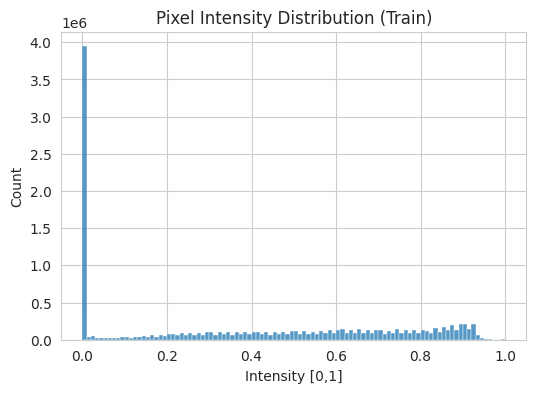

In [63]:
X_train = np.load(os.path.join(NPY_ROOT, "train", "X.npy"))

plt.figure(figsize=(6,4))
sns.histplot(X_train.flatten(), bins=100)
plt.title("Pixel Intensity Distribution (Train)")
plt.xlabel("Intensity [0,1]")
plt.show()


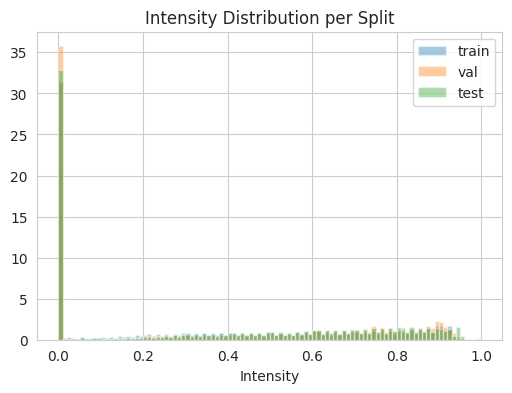

In [64]:
plt.figure(figsize=(6,4))

for split in ["train", "val", "test"]:
    X = np.load(os.path.join(NPY_ROOT, split, "X.npy"))
    plt.hist(
        X.flatten(),
        bins=100,
        alpha=0.4,
        density=True,
        label=split
    )

plt.legend()
plt.title("Intensity Distribution per Split")
plt.xlabel("Intensity")
plt.show()


In [65]:
png_norm = png.astype(np.float32) / 255.0
diff = np.abs(png_norm - npy)

print("Max absolute difference PNG vs NPY:", diff.max())


Max absolute difference PNG vs NPY: 0.0


In [66]:
df.groupby(["split", "label"]).size()


split  label
test   NonTB    2
       TB       2
train  NonTB    7
       TB       5
val    NonTB    2
       TB       2
dtype: int64

In [67]:
def show_grid(split, label, n=9):
    subset = df[(df["split"] == split) & (df["label"] == label)].sample(n)
    fig, ax = plt.subplots(3, 3, figsize=(6,6))
    for i, (_, r) in enumerate(subset.iterrows()):
        img = cv2.imread(r["png_path"], cv2.IMREAD_GRAYSCALE)
        ax[i//3, i%3].imshow(img, cmap="gray")
        ax[i//3, i%3].axis("off")
    plt.suptitle(f"{split.upper()} – {label}")
    plt.show()

for split in ["train", "val", "test"]:
    show_grid(split, "TB")
    show_grid(split, "NonTB")


ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
assert df["final_size"].nunique() == 1
assert (df[pad_cols] >= 0).all().all()

for split in ["train", "val", "test"]:
    X = np.load(os.path.join(NPY_ROOT, split, "X.npy"))
    assert X.shape[1:] == (1024, 1024, 1)

print("All preprocessing assertions passed.")


✅ All preprocessing assertions passed.


In [ ]:
print("===== EDA CONVERSION SUMMARY =====")
print("Total images:", len(df))
print("\nSplit × Label:")
print(df.groupby(["split", "label"]).size())
print("\nResolution (original):")
print(df[["orig_width", "orig_height"]].describe())


===== EDA CONVERSION SUMMARY =====
Total images: 20

Split × Label:
split  label
test   NonTB    2
       TB       2
train  NonTB    7
       TB       5
val    NonTB    2
       TB       2
dtype: int64

Resolution (original):
        orig_width  orig_height
count    20.000000     20.00000
mean   2233.600000   2619.45000
std     163.134559    321.01426
min    1824.000000   2020.00000
25%    2175.000000   2365.25000
50%    2336.000000   2836.00000
75%    2336.000000   2836.00000
max    2336.000000   2836.00000
